In [1]:
%matplotlib inline
import sys
sys.version

'3.7.9 (default, Jan 24 2021, 23:57:56) \n[GCC 10.2.0]'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import json
from matplotlib.ticker import MaxNLocator

In [3]:
filename = "../../../long-results/2021-07-13T16:27:13_inv_singleServerSingleGPU_120000_0.5_600000_120000_2.5.json"
#filename = "../../../long-results/2021-07-03T23:00:09_inv_allIhaveDOUBLE_120000_4_600000_120000_8.json"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

ps = filename.split("_")
trps = dotdict({
    'p0': int(ps[3])/1000,
    'p0t': float(ps[4]),
    'p1': int(ps[5])/1000,
    'p2': int(ps[6])/1000,
    "p2t": float(ps[7].replace(".json", ""))
})

In [4]:
dict_for_colors = {}
get_counter_of_pid_list = []
available_colors = ['g','r','c','m','y','k']*1000000

def assign_color_to_hostname_pid(hostname, pid) -> str:
    key = hostname + pid
    if not key in dict_for_colors:
        dict_for_colors[key] = available_colors[len(dict_for_colors)]
    return dict_for_colors[key]

def get_uid_of_ri(pid, hostname, accelerator) -> int:
    key = str(pid) + str(hostname) + str(accelerator)
    try:
        val =  get_counter_of_pid_list.index(key)
        return val
    except Exception:
        get_counter_of_pid_list.append(key)
        return get_counter_of_pid_list.index(key)

def accelerator_type_from_accelerator(acc) -> str:
    if acc == "mycpu":
        return "cpu"
    if acc == "0" or acc == "1":
        return "gpu"
    if acc == "main.py": ## I don't understand this either
        return "vpu"

In [5]:
with open(filename) as f:
    d = json.load(f)
data = json_normalize(d)

print(data)

failed = [end == -1 for end in data['end']]
data.insert(0, "failed", failed)

if data.start.min() != 0:
    global experiment_start
    experiment_start = data.start.min()

data.start = data.start - experiment_start
data.end = data.end - experiment_start
data['result.start_computation'] = data['result.start_computation'] - experiment_start
data['result.end_computation'] = data['result.end_computation'] - experiment_start
data['result.metadata.start'] = data['result.metadata.start'] - experiment_start
data['result.metadata.end'] = data['result.metadata.end'] - experiment_start

# End to End Latency
data.insert(0,"rlat",data.end - data.start)

# Distr
data.insert(0, "dlat", data.rlat - data['result.metadata.inference_ms'])

data.insert(0, "rfast", data.rlat <= 7000)

data

                end          start       inv.configuration  \
0     1626185263570  1626185254191  test|tinyyolov2-7.onnx   
1     1626185263595  1626185254191  test|tinyyolov2-7.onnx   
2     1626185263584  1626185254191  test|tinyyolov2-7.onnx   
3     1626185263559  1626185254191  test|tinyyolov2-7.onnx   
4     1626185263605  1626185254191  test|tinyyolov2-7.onnx   
...             ...            ...                     ...   
1245  1626186289730  1626186084231  test|tinyyolov2-7.onnx   
1246  1626186300136  1626186084329  test|tinyyolov2-7.onnx   
1247  1626186297401  1626186084285  test|tinyyolov2-7.onnx   
1248  1626186294631  1626186084246  test|tinyyolov2-7.onnx   
1249  1626186291895  1626186084304  test|tinyyolov2-7.onnx   

                   inv.params.callbackUrl inv.params.payload  \
0     localhost:3358/QAAdEW1vijzOn45odV9o                      
1     localhost:3358/2PLTevxo60EFN0Qx8E4J                      
2     localhost:3358/Na8fMtFqgoiQcKAzvqEI                      

,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,False,6047.442488,9379,False,9379,0,test|tinyyolov2-7.onnx,localhost:3358/QAAdEW1vijzOn45odV9o,,minio-admin,...,3331.557512,sandybridge-ep,4.253237e+03,7.584794e+03,109835,,[output.bin],reference,3157.0,NaN
1,False,8268.691257,9404,False,9404,0,test|tinyyolov2-7.onnx,localhost:3358/2PLTevxo60EFN0Qx8E4J,,minio-admin,...,1135.308743,sandybridge-ep,7.503737e+03,8.639045e+03,109832,,[output.bin],reference,7500.0,NaN
2,False,6071.828001,9393,False,9393,0,test|tinyyolov2-7.onnx,localhost:3358/Na8fMtFqgoiQcKAzvqEI,,minio-admin,...,3321.171999,sandybridge-ep,4.275732e+03,7.596905e+03,109839,,[output.bin],reference,3157.0,NaN
3,False,6080.606907,9368,False,9368,0,test|tinyyolov2-7.onnx,localhost:3358/v8mmR3OEWEwxphq6YbP8,,minio-admin,...,3287.393093,sandybridge-ep,4.179916e+03,7.467309e+03,109832,,[output.bin],reference,3157.0,NaN
4,False,7969.073023,9414,False,9414,0,test|tinyyolov2-7.onnx,localhost:3358/GcxEcjbSQSkH4PpgS7Xh,,minio-admin,...,1444.926977,sandybridge-ep,7.617625e+03,9.062552e+03,109835,,[output.bin],reference,7613.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,False,204157.410072,205499,False,1035539,830040,test|tinyyolov2-7.onnx,localhost:3358/OPt5Qnuhwteb7FA2czjL,,minio-admin,...,1341.589928,sandybridge-ep,1.034143e+06,1.035485e+06,109839,,[output.bin],reference,1034141.0,NaN
1246,False,214456.335623,215807,False,1045945,830138,test|tinyyolov2-7.onnx,localhost:3358/nkgaAKniCnxMqhEp2soJ,,minio-admin,...,1350.664377,sandybridge-ep,1.044540e+06,1.045890e+06,109835,,[output.bin],reference,1044538.0,NaN
1247,False,211748.431746,213116,False,1043210,830094,test|tinyyolov2-7.onnx,localhost:3358/TLGTpfNnc5RQrigPf5DS,,minio-admin,...,1367.568254,sandybridge-ep,1.041789e+06,1.043156e+06,109835,,[output.bin],reference,1041787.0,NaN
1248,False,209042.716513,210385,False,1040440,830055,test|tinyyolov2-7.onnx,localhost:3358/VFVzqPcIhsKtNnBZ6u1n,,minio-admin,...,1342.283487,sandybridge-ep,1.039043e+06,1.040386e+06,109835,,[output.bin],reference,1039041.0,NaN


In [6]:
print('Number of failed invocations:', len(data.loc[data['failed'] == True].index))
data.loc[data['failed'] == True]

Number of failed invocations: 1


,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
67,True,NaN,-1626185384191,True,-1626185254192,129999,test|tinyyolov2-7.onnx,localhost:3358/RXqudIP3vwlTasvOJGZk,,minio-admin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data = data.loc[data['failed'] == False]
data

,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,False,6047.442488,9379,False,9379,0,test|tinyyolov2-7.onnx,localhost:3358/QAAdEW1vijzOn45odV9o,,minio-admin,...,3331.557512,sandybridge-ep,4.253237e+03,7.584794e+03,109835,,[output.bin],reference,3157.0,NaN
1,False,8268.691257,9404,False,9404,0,test|tinyyolov2-7.onnx,localhost:3358/2PLTevxo60EFN0Qx8E4J,,minio-admin,...,1135.308743,sandybridge-ep,7.503737e+03,8.639045e+03,109832,,[output.bin],reference,7500.0,NaN
2,False,6071.828001,9393,False,9393,0,test|tinyyolov2-7.onnx,localhost:3358/Na8fMtFqgoiQcKAzvqEI,,minio-admin,...,3321.171999,sandybridge-ep,4.275732e+03,7.596905e+03,109839,,[output.bin],reference,3157.0,NaN
3,False,6080.606907,9368,False,9368,0,test|tinyyolov2-7.onnx,localhost:3358/v8mmR3OEWEwxphq6YbP8,,minio-admin,...,3287.393093,sandybridge-ep,4.179916e+03,7.467309e+03,109832,,[output.bin],reference,3157.0,NaN
4,False,7969.073023,9414,False,9414,0,test|tinyyolov2-7.onnx,localhost:3358/GcxEcjbSQSkH4PpgS7Xh,,minio-admin,...,1444.926977,sandybridge-ep,7.617625e+03,9.062552e+03,109835,,[output.bin],reference,7613.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,False,204157.410072,205499,False,1035539,830040,test|tinyyolov2-7.onnx,localhost:3358/OPt5Qnuhwteb7FA2czjL,,minio-admin,...,1341.589928,sandybridge-ep,1.034143e+06,1.035485e+06,109839,,[output.bin],reference,1034141.0,NaN
1246,False,214456.335623,215807,False,1045945,830138,test|tinyyolov2-7.onnx,localhost:3358/nkgaAKniCnxMqhEp2soJ,,minio-admin,...,1350.664377,sandybridge-ep,1.044540e+06,1.045890e+06,109835,,[output.bin],reference,1044538.0,NaN
1247,False,211748.431746,213116,False,1043210,830094,test|tinyyolov2-7.onnx,localhost:3358/TLGTpfNnc5RQrigPf5DS,,minio-admin,...,1367.568254,sandybridge-ep,1.041789e+06,1.043156e+06,109835,,[output.bin],reference,1041787.0,NaN
1248,False,209042.716513,210385,False,1040440,830055,test|tinyyolov2-7.onnx,localhost:3358/VFVzqPcIhsKtNnBZ6u1n,,minio-admin,...,1342.283487,sandybridge-ep,1.039043e+06,1.040386e+06,109835,,[output.bin],reference,1039041.0,NaN


In [8]:
# (semi-)unique color per runtime instance
acc_color = [assign_color_to_hostname_pid(hostname, pid) for hostname,pid in zip(data['result.metadata.hostname'], data['result.pid'])]
data.insert(0,"acc_color", acc_color)

# unique id for every pid, starting with 0 (may be used as y-axis in some images)
inst_id = [get_uid_of_ri(pid, hn, acc) for pid,hn,acc in zip(data['result.pid'],data['result.metadata.hostname'],data['result.accelerator'])]
data.insert(0, "inst_id", inst_id)

# String that identifies the type of accelerator
acc_type = [accelerator_type_from_accelerator(acc) for acc in data['result.accelerator']]
data.insert(0, "acc_type", acc_type)

acc_name = [str(hn) + "-" + str(acc) for hn,acc in zip(data['result.metadata.hostname'], data['result.accelerator'])]
data.insert(0, "acc_name", acc_name)

In [9]:
data.columns

Index(['acc_name', 'acc_type', 'inst_id', 'acc_color', 'rfast', 'dlat', 'rlat',
       'failed', 'end', 'start', 'inv.configuration', 'inv.params.callbackUrl',
       'inv.params.payload', 'inv.params.payload_reference.bucket.accessKey',
       'inv.params.payload_reference.bucket.bucketName',
       'inv.params.payload_reference.bucket.endpoint',
       'inv.params.payload_reference.bucket.secretKey',
       'inv.params.payload_reference.file', 'inv.params.payload_type',
       'inv.params.resultBucket.accessKey',
       'inv.params.resultBucket.bucketName',
       'inv.params.resultBucket.endpoint', 'inv.params.resultBucket.secretKey',
       'inv.runtime', 'result.accelerator', 'result.amount',
       'result.end_computation', 'result.metadata.inference_ms',
       'result.metadata.hostname', 'result.metadata.start',
       'result.metadata.end', 'result.pid', 'result.request', 'result.result',
       'result.result_type', 'result.start_computation', 'result'],
      dtype='object')

In [10]:
def print_stats(df):
    print(f'Total requests: {df.size}')
    inf = df['result.metadata.inference_ms']
    print(f'Inference: mean={inf.mean()}, std={inf.std()}')
    print(f'Total Duration: mean={df.rlat.mean()}, std={df.rlat.std()}')
    com = df['result.end_computation'] - df['result.start_computation']
    print(f'Total Computation (inference+upload): mean={com.mean()}, std={com.std()}')
    tts = df['result.start_computation'] - df.start
    print(f'Time from invocation to start_computation: mean={tts.mean()}, std={tts.std()}')
    print()

print('results total: ')
print_stats(data)

hosts = data['result.metadata.hostname'].unique()

for host in hosts:
    print(f'results for host {host}: ')
    print_stats(data.loc[data['result.metadata.hostname'] == host])

#print('results home: ')
#print_stats(data.loc[data['result.metadata.hostname'] != 'sandybridge-ep'])

results total: 
Total requests: 46213
Inference: mean=1391.2938542133145, std=189.36584814231875
Total Duration: mean=67855.07686148919, std=68073.86646611408
Total Computation (inference+upload): mean=1399.105684547638, std=233.0464491805718
Time from invocation to start_computation: mean=66396.68454763811, std=68083.53964180197

results for host sandybridge-ep: 
Total requests: 46213
Inference: mean=1391.2938542133145, std=189.36584814231875
Total Duration: mean=67855.07686148919, std=68073.86646611408
Total Computation (inference+upload): mean=1399.105684547638, std=233.0464491805718
Time from invocation to start_computation: mean=66396.68454763811, std=68083.53964180197



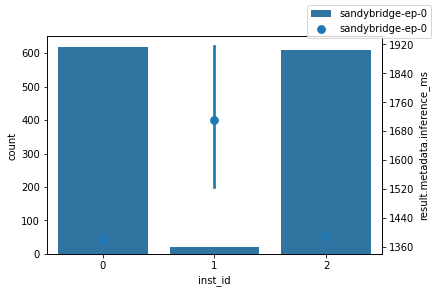

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("ELat [ms]")
ax.set_xlabel("Time since start [s]")
sns.countplot(ax=ax, data=data, x='inst_id', hue='acc_name')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel("Requests computed [#]")
sns.pointplot(ax=ax2, data=data, x='inst_id', y='result.metadata.inference_ms', hue='acc_name', join=False)
ax2.get_legend().remove()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(loc="upper right")

Used Runtime Instances and when they were active


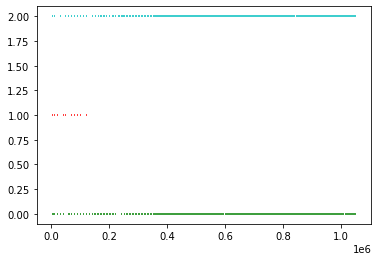

In [12]:
plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=data.acc_color, linestyle="solid")
#plt.scatter(data.start, data.inst_id)
print("Used Runtime Instances and when they were active")

In [13]:
def generate_seconds(data, rstart=True):
    # Plot by RStart
    min, max = 0, 0
    if rstart:
        max = int(data.start.max() / 1000) # Rounds down to the latest second
        min = 0 # Per definition for the start
    else:
        # Plot by EStart
        max = int(data['result.start_computation'].max() / 1000)
        min = int(data['result.start_computation'].min() / 1000)
    data_smooth = data.rolling(100).mean()

    seconds_d = {
        # Request-Response Latency
        'rlat_min': [],
        'rlat_med': [],
        'rlat_max': [],
        # Execution Start-End Latency
        'elat_min': [],
        'elat_med': [],
        'elat_max': [],
        # Number of successful invocations
        'rsuccess': [],
        #'rfast_min': [],
        'rfast_avg': [],
        #'rfast_max': []
    }

    for i in range(min, max):
        t_min = i * 1000
        t_max = (i+1) * 1000
        # For Host Selection:
        # (data['result.metadata.hostname'] != 'sandybridge-ep') & 
        # Plot by RStart
        curr = data.loc[(data.start >= t_min) & (data.start < t_max)]
        curr_smooth = data_smooth.loc[(data.start >= t_min) & (data.start < t_max)]
        # Plot by EStart
        #curr = data.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
        #curr_smooth = data_smooth.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
        seconds_d['rlat_min'].append(curr.rlat.min())
        seconds_d['rlat_med'].append(curr.rlat.median())
        seconds_d['rlat_max'].append(curr.rlat.max())

        seconds_d['elat_min'].append(curr['result.metadata.inference_ms'].min())
        seconds_d['elat_med'].append(curr['result.metadata.inference_ms'].median())
        seconds_d['elat_max'].append(curr['result.metadata.inference_ms'].max())

        next10s = data.loc[(data.start >= t_min) & (data.start < t_min + 10000)]
        seconds_d['rsuccess'].append(next10s.shape[0]/10)
        #seconds_d['rfast_min'].append(next10s.loc[next10s['rfast']].min())
        seconds_d['rfast_avg'].append(next10s.loc[next10s['rfast']].shape[0]/10)
        #seconds_d['rfast_max'].append(next10s.loc[next10s['rfast']].max())

    seconds = pd.DataFrame(seconds_d)
    seconds_smooth = seconds.rolling(10).mean()
    return seconds, seconds_smooth
seconds, seconds_smooth = generate_seconds(data)

In [14]:
def plot_seconds(data, data_smooth):
    fig = plt.figure()
    ax = plt.axes()
    ax.set_ylabel("Latency [ms]")
    ax.set_xlabel("Time since start [s]")
    rlat = sns.lineplot(ax=ax, data=data, x=data.index, y='rlat_med', label="RLat")
    elat = sns.lineplot(ax=ax, data=data, x=data.index, y='elat_med', label="ELat")
    rlats = ax.fill_between(data.index, data['rlat_min'], data['rlat_max'], alpha=0.4)
    elats = ax.fill_between(data.index, data['elat_max'], data['elat_min'], alpha=0.4)
    ax.get_legend().remove()

    ax2 = ax.twinx()
    ax2.set_ylabel("Requests/s [#]")
    sns.scatterplot(ax=ax2, data=data_smooth, x=data.index, y='rsuccess', label="RSuccess", color="g")
    sns.scatterplot(ax=ax2, data=data, x=data.index, y='rfast_avg', label="RFast", color="r")
    ##ax2.fill_between(x=data.index, y1=data['rfast_min'], y2=data['rfast_max'], alpha=0.4)
    sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")
    ax2.get_legend().remove()
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    fig.legend(loc="upper right", bbox_to_anchor=(1.2, 0.8))
    plt.show()

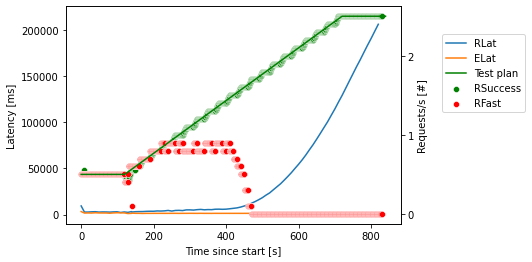

In [15]:
# .loc[(seconds['rlat_min'] > 0) & (seconds['rlat_min'] < 150000)] to see error bars
plot_seconds(seconds, seconds_smooth)

In [16]:
# Read the gpu+queue util as well
util = pd.read_pickle(ps[0] + "_stats.pkl")
util['time'] = util['time'] - experiment_start
experiment_dur = data['end'].max() * 1000
util = util.loc[util['time'] > 0]
util = util.loc[util['time'] < experiment_start + experiment_dur]

util['time'] = util['time']/1000 # convert to seconds
#util

<AxesSubplot:ylabel='Requests/s [#]'>

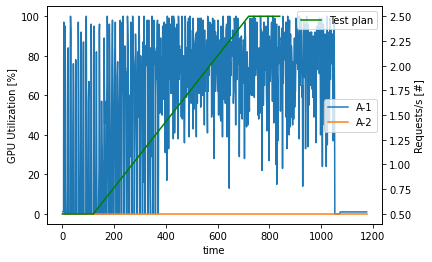

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("GPU Utilization [%]")

sns.lineplot(ax=ax,data=util, x='time', y='util_gpu1', label="A-1")
sns.lineplot(ax=ax,data=util, x='time', y='util_gpu2', label="A-2")
#sns.lineplot(ax=ax,data=util, x='time', y='queued', label="Queued invocations")
#sns.lineplot(ax=ax,data=util, x='time', y='util_gpu3', label="B-1")

ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [#]")
sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")

<AxesSubplot:ylabel='Requests/s [#]'>

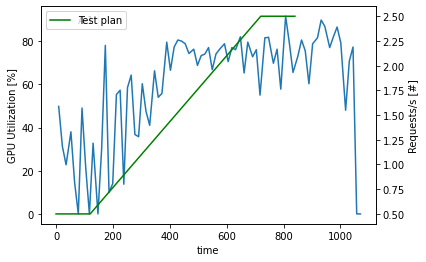

In [35]:
rolling = util.rolling(4).mean()
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("GPU Utilization [%]")

sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu1', label="A-1")
#sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu2', label="A-2")
#sns.lineplot(ax=ax,data=rolling, x='time', y='queued', label="Queued invocations")
#sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu3', label="B-1", color="y")

ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [#]")
sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")

In [23]:
util.loc[util['util_gpu1'] > 0]

,time,util_gpu1,util_mem1,util_gpu2,util_mem2,queued
4,1.809,1.0,0.0,0.0,0.0,5.0
5,2.809,1.0,0.0,0.0,0.0,2.0
7,4.809,1.0,0.0,0.0,0.0,2.0
8,5.809,97.0,35.0,0.0,0.0,2.0
10,7.809,70.0,10.0,0.0,0.0,0.0
...,...,...,...,...,...,...
1172,1169.809,1.0,0.0,0.0,0.0,0.0
1173,1170.809,1.0,0.0,0.0,0.0,0.0
1175,1172.809,1.0,0.0,0.0,0.0,0.0
1176,1173.809,1.0,0.0,0.0,0.0,0.0


In [19]:
## Only applicable for dual
original = data
onnx = data.loc[data['inv.runtime'] == 'onnx']
onnx2 = data.loc[data['inv.runtime'] == 'onnx2']

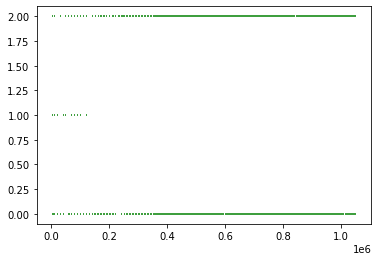

In [20]:
plt.hlines(y=onnx.inst_id, xmin=onnx['result.start_computation'], xmax=onnx['result.end_computation'], colors="g", linestyle="solid")
plt.hlines(y=onnx2.inst_id, xmin=onnx2['result.start_computation'], xmax=onnx2['result.end_computation'], colors="r", linestyle="solid")

In [21]:
seconds_o, seconds_smooth_o = generate_seconds(onnx)
seconds_o2, seconds_smooth_o2 = generate_seconds(onnx2)
plot_seconds(seconds_o, seconds_smooth_o)
plot_seconds(seconds_o2, seconds_smooth_o2)

ValueError: cannot convert float NaN to integer

In [ ]:
seconds

In [ ]:
seconds.loc[/seconds['rlat_min'] > 0 & seconds['rlat_min'] < 10000]